# ECG Classification with Transformer-Encode-Model 

Classification of ECG data into two classes, myocardial infarction and no myocardial infarction


**Autor:** Fabian Schoch  
**Datum:** 16.02.2024


# Import Packages

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import Library.TimeSeries.Transformer as trafo
import Library.TimeSeries.PreProcessing as pp
import Library.TimeSeries.LearningRateSchedule as lrs

# Loading the Data

Load the data from csv files. The data is already pre-processed and ready to use for the model. Each sample represents a heartbeat. \
Source of preprocessed data https://www.kaggle.com/datasets/shayanfazeli/heartbeat \
Orginal dataset from https://physionet.org/content/ptbdb/1.0.0/


In [2]:
norm = pd.DataFrame( pd.read_csv('Data/MIT-BIH_PTB/ptbdb_normal.csv'))
myocardial_infarction =  pd.DataFrame( pd.read_csv('Data/MIT-BIH_PTB/ptbdb_abnormal.csv'))

print("Number of myocardial infarction samples (class 0):", myocardial_infarction.shape[0])
print("Number of normal samples (class 1):", norm.shape[0], "\n")

Number of myocardial infarction samples (class 0): 10505
Number of normal samples (class 1): 4045 



## Show some samples from each class

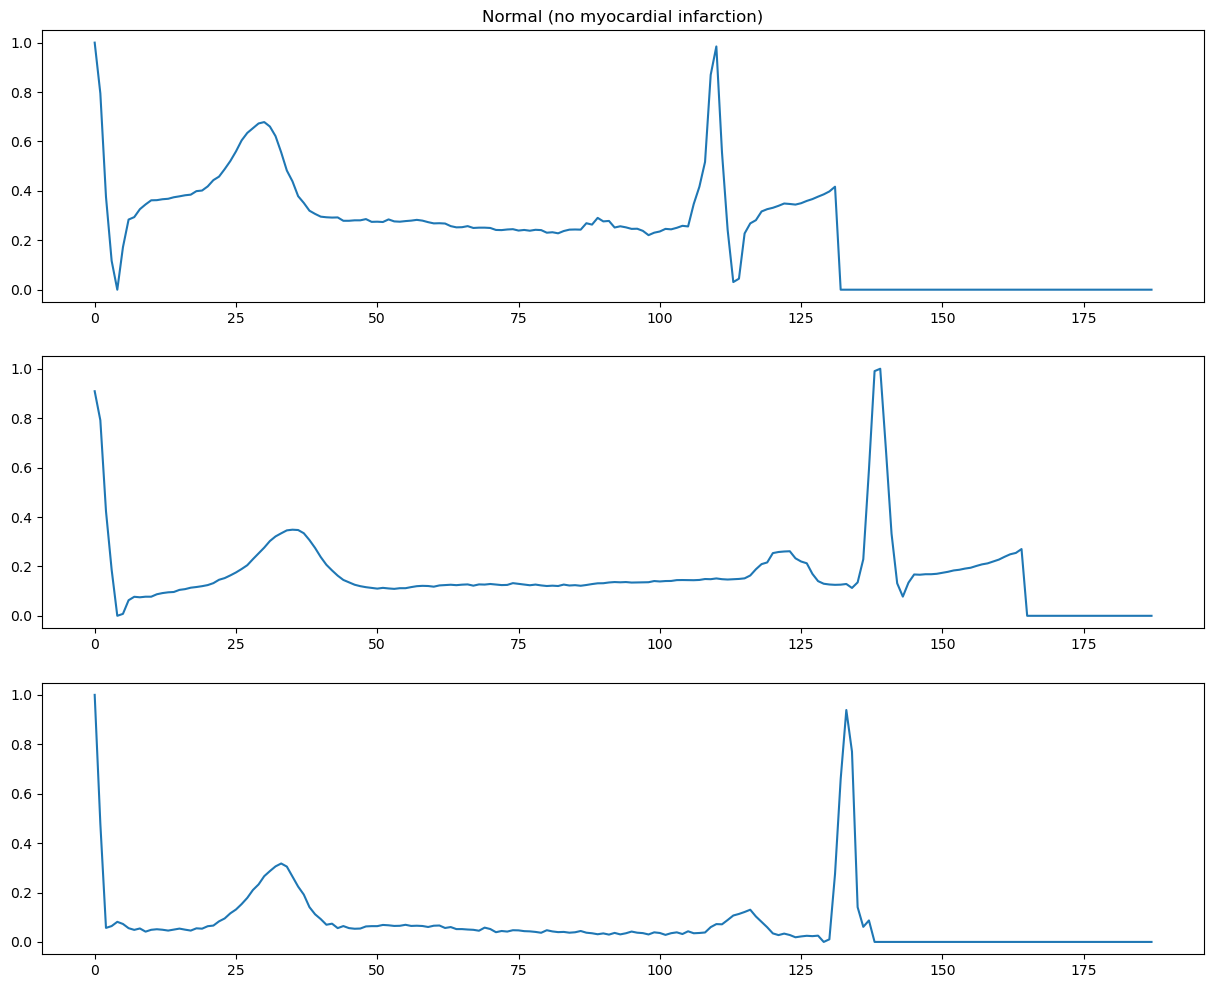

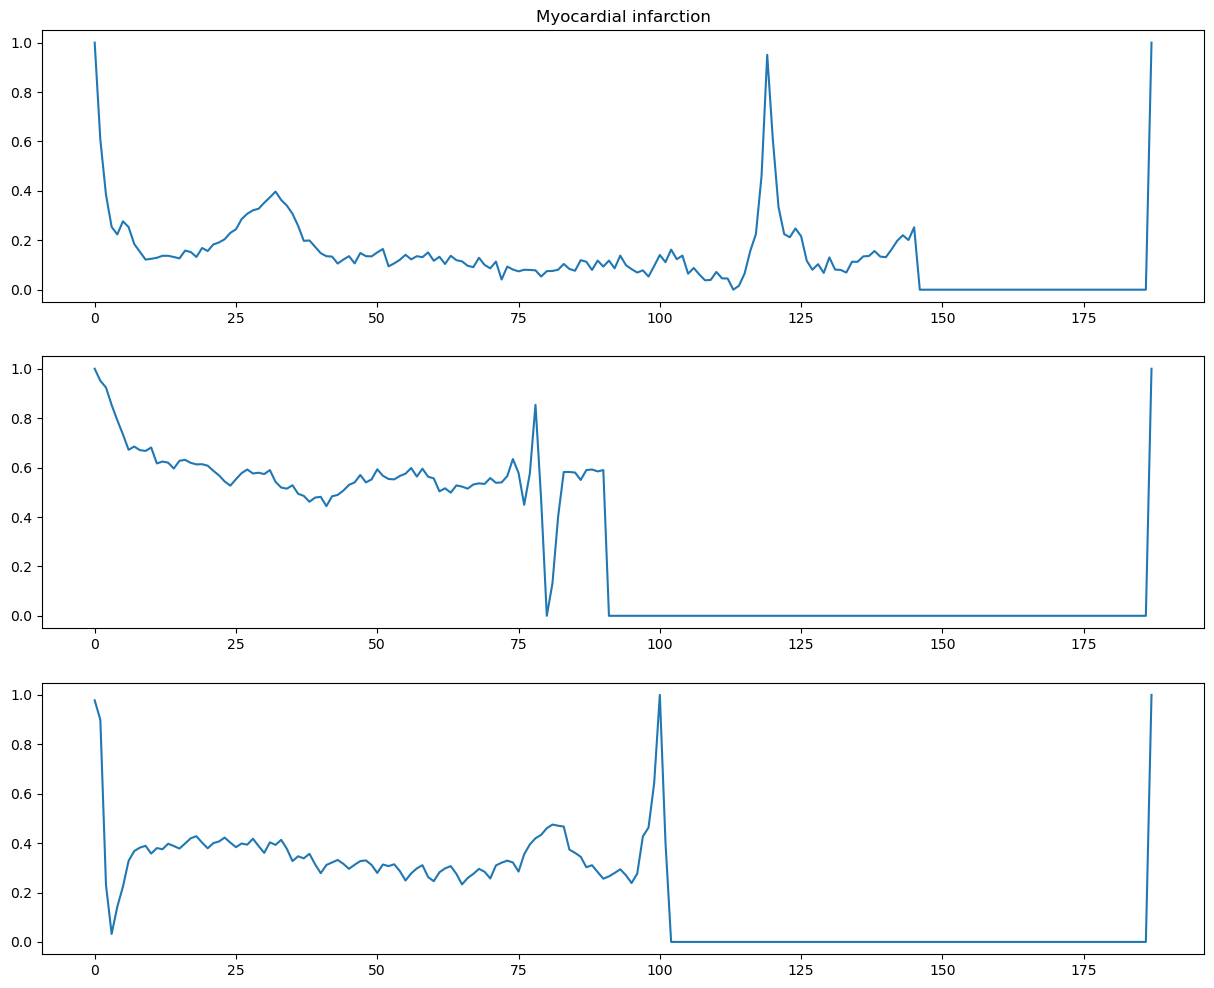

In [3]:
number_of_samples_to_plot = 3

myocardial_infarction = np.array(myocardial_infarction)
norm = np.array(norm)

fig = plt.figure()
fig.set_figheight(4*number_of_samples_to_plot)
fig.set_figwidth(15)
ax = []
for i in range(number_of_samples_to_plot):
    ax += [fig.add_subplot(number_of_samples_to_plot,1,i+1)]
    ax[i].plot(norm[i])
ax[0].title.set_text('Normal (no myocardial infarction)')
plt.show()


fig = plt.figure()
fig.set_figheight(4*number_of_samples_to_plot)
fig.set_figwidth(15)
ax = []
for i in range(number_of_samples_to_plot):
    ax += [fig.add_subplot(number_of_samples_to_plot,1,i+1)]
    ax[i].plot(myocardial_infarction[i])
ax[0].title.set_text('Myocardial infarction')
plt.show()

## Meaning of the Data 

In the case of a fresh myocardial infarction, an excessive T wave occurs. This symptom is also known as a "choking T". The ST elevation (elevation of the ST segment) is an early sign of an infarction. It often merges with the subsequent T wave. It is often also referred to as an ST elevation myocardial infarction or STEMI (https://www.praktischarzt.de/untersuchungen/ekg/)

According to the description in www.praktischarzt.de, the striking features in the time series for distinguishing the two classes are in the ST and T wave, see red frame in the image. We will come back to this area later when analyzing the results. 

<img src="Images/EKG.png" style="width: 500px;"/> \
(https://www.praktischarzt.de/untersuchungen/ekg/) \ 


The difference between the visualization of this image and our data is the start of the heartbeat. The image starts with the P wave and our data starts with the R-peak and end with the R-peak plus view time steps extra.



## Data Preperation

Concatinent the myocardial infarction data with the normal data and shuffle the data. \
Due to class imbalance, we use class weights

In [4]:

#Concat the both datasets
data = np.append(myocardial_infarction,norm, axis=0)

#Shuffel 
data = pd.DataFrame(data).sample(frac = 1, random_state=24)
print("Sequenz size of one sample", data.shape[-1], "\n")

#Set class names
class_names = {0: 'Normal' , 1: 'Myocardial Infarction' }
#Number of classes
num_classes=len(class_names)

#Due to class imbalance, we use class weights
data_count = len(norm)+len(myocardial_infarction)
class_weight = {0: (data_count/(2*len(myocardial_infarction))),  1:(data_count/(2*len(norm)))}

Sequenz size of one sample 188 



## Split the Data in train, valid, test and seperate the labels 

The first 187 datapoint per sample is the ECG recording and the last 188th point is the label, as we see in the plots the 188th datapoint in myocardial infarction is 1 and the normal is 0.



In [5]:
print("Data sahep with label and not splited:", data.shape)

train, valid_test = train_test_split(data, test_size=0.30, random_state = 42)
valid, test = train_test_split(valid_test, test_size=0.50, random_state = 42)

x_train = np.array(train.iloc[:, 0:-1])
y_train = np.array(train.iloc[:, -1])
y_train = y_train[:,np.newaxis]

x_valid = np.array(valid.iloc[:, 0:-1])
y_valid = np.array(valid.iloc[:, -1])
y_valid = y_valid[:,np.newaxis]

x_test = np.array(test.iloc[:, 0:-1])
y_test = np.array(test.iloc[:, -1])
y_test = y_test[:,np.newaxis]


print("Data shape of the tranings ecg record", x_train.shape)
print("Data shape of the tranings label", y_train.shape)


Data sahep with label and not splited: (14550, 188)
Data shape of the tranings ecg record (10185, 187)
Data shape of the tranings label (10185, 1)


## Convert labels into one hot encoding 


In [6]:
y_train = y_train.astype('int')
y_train = tf.one_hot(y_train, len(class_names))
y_train = np.squeeze(y_train)

y_valid = y_valid.astype('int')
y_valid = tf.one_hot(y_valid, len(class_names))
y_valid = np.squeeze(y_valid)

y_test = y_test.astype('int')
y_test = tf.one_hot(y_test, len(class_names))
y_test = np.squeeze(y_test)

print("Data shape of the one hot encoded tranings label", y_train.shape)

Data shape of the one hot encoded tranings label (10185, 2)


# Add Time Stamp

The transformer model needs a time stamp at each position in the sequence to better understand the position of the data points in the series and their context.

In [7]:
print("trainings data without timestamp:", x_train.shape)

x_train = pp.add_time_stamp(np.array(x_train)[:,:,np.newaxis], lower_value=0)
x_valid = pp.add_time_stamp(np.array(x_valid)[:,:,np.newaxis], lower_value=0)
x_test = pp.add_time_stamp(np.array(x_test)[:,:,np.newaxis], lower_value=0)

print("trainings data with timestamp:", x_train.shape)

trainings data without timestamp: (10185, 187)
trainings data with timestamp: (10185, 187, 2)


# Transformer-Encoder-Model

## Define Hyperparameter

The right choise of the hyperparameter is a chalanging task. Experince and tries are necessary, to find good parameter.

### Segmentation

The segmentation of input data for time series transformer models has proven to be a good way to improve performance and reduce computing power. (https://arxiv.org/abs/2202.11356, https://arxiv.org/abs/2202.07125)\
This is realized with a CNN layer, where not every single point in time series but ranges (segments) are taken as input for the transformer, so a token (an input element of the transformer) is not just one point in time but several. Illustrated in the following diagram

<img src="Images/Segmentation.png" style="width: 700px;"/> \

These segments can also overlap. \
The segment_size parameter specifies the size of the segments. 
The segment_stride parameter specifies how much the segments overlap, the value is the distance to the next segment.\

In [8]:
segment_size = 32
segment_stride = 4

### Encoder Part

These are the parameters for the actual Transformer. Further information can be found in the original publication "Attention is all you need" (https://arxiv.org/abs/1706.03762) \
A short information about the Architecture is given in the following image: 

<img src="Images/EncoderTransformer.png" style="width: 300px;"/> \
(Based on https://arxiv.org/abs/1706.03762)

Attention heads are a crucial component in Transformer models. They are an innovative method for processing sequential data, especially in NLP.
All input tokens (input elements) of the transformer are placed in relation to themselves so that every point is considered in relation to every point. In this way, the context of each individual point is considered. This is crucial in NLP (language processing). But it can also be used to process time series as these are sequential data like speech.


In [9]:
model_dimension = 48 
num_layers = 1  #Nx
num_heads = 6   #h
encoder_feed_forward = 128  # EFFx    
encoder_dropout_rate = 0.3

### The Classification Layer

After the Transformer, the output has the same dimension as the input. All the tokens we put into the transformer come out with the context of all the other tokens. With this output from the transformer we now need to perform classification. Since it is not performant to use a classification token with a small model and a small dataset like this, we use all the output tokens of the transformer to do the classification. Because the output of the transformer is not small, reducing it through the CNN layer improves the convergence of the model.

In [10]:
dropout_rate_after_enocder = 0.05 #DOx
cnn_blocks = 2  #CNNx
output_feed_forward_layer = [128, 128] #FFx

At least we define the batch size and the number of epochs we want to train the model

In [11]:
batch_size = 128
training_epochs = 50

### Create the Model 

We do not use a fixed learning rate, the learning rate increases at the beginning to a defined value (warm-up) and decreases exponentially with time. \
The optimizer is Adam and we use the categorical cross entropy as the loss function.

In [12]:

model = trafo.EncoderTransformer(
    num_layers=num_layers,
    model_dimension=model_dimension,            
    num_heads=num_heads,
    encoder_feed_forward=encoder_feed_forward,                    
    model_output_size = y_train.shape[-1],
    encoder_dropout_rate=encoder_dropout_rate,
    output_feed_forward_layer= output_feed_forward_layer,
    classification = True,
    dropout_rate_after_enocder= dropout_rate_after_enocder,
    segment_sizes=segment_size,
    segment_stride = segment_stride,
    cnn_layer_after_encoder = cnn_blocks,
    cls_token=False
    )


model.build(input_shape=[batch_size, x_train.shape[1], x_train.shape[2]])

steps_per_epoch = len(x_train) // batch_size
learning_rate = lrs.ExponentialDecayWithWarmup( warmup_steps=steps_per_epoch*5, inital_learning_rate=5e-4, decay_steps=steps_per_epoch*10, decay_rate=0.6)
optimizer = tf.keras.optimizers.Adam(learning_rate)

model.compile( loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

model.summary()


Model: "encoder_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segmentation_projektion (Se  multiple                 3216      
 gmentationProjektion)                                           
                                                                 
 encoder_layer (EncoderLayer  multiple                 68864     
 )                                                               
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 cnn__block (CNN_Block)      multiple                  23136     
                                                                 
 cnn__block_1 (CNN_Block)    multiple                  23136     
                                                                 
 flatten (Flatten)           multiple          

# Model Training

Now we train the model, this may take a few minutes. \
We also use an early stopping call-back to stop the training if there is no increase in performance for 10 epochs. \
Tranings Time: \
~2 minutes with GPU \
~10-15 minutes with CPU  


In [13]:
eraly_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    restore_best_weights = True,  
    patience = 10
)


model_history = model.fit(
            x = x_train,
            y = y_train,  
            validation_data = (x_valid, y_valid),          
            steps_per_epoch = steps_per_epoch,
            batch_size = batch_size,
            epochs = training_epochs,
            callbacks = [eraly_stopping],            
            class_weight = class_weight,
            )

Epoch 1/50
79/79 [==============================] - 6s 32ms/step - loss: 0.6802 - accuracy: 0.6797 - val_loss: 0.5372 - val_accuracy: 0.7232
Epoch 2/50
79/79 [==============================] - 2s 26ms/step - loss: 0.4582 - accuracy: 0.7337 - val_loss: 0.4310 - val_accuracy: 0.7924
Epoch 3/50
79/79 [==============================] - 2s 26ms/step - loss: 0.3912 - accuracy: 0.7749 - val_loss: 0.3457 - val_accuracy: 0.8497
Epoch 4/50
79/79 [==============================] - 2s 26ms/step - loss: 0.3301 - accuracy: 0.8274 - val_loss: 0.2827 - val_accuracy: 0.8639
Epoch 5/50
79/79 [==============================] - 2s 26ms/step - loss: 0.2603 - accuracy: 0.8704 - val_loss: 0.2194 - val_accuracy: 0.9115
Epoch 6/50
79/79 [==============================] - 2s 26ms/step - loss: 0.2076 - accuracy: 0.9057 - val_loss: 0.1470 - val_accuracy: 0.9432
Epoch 7/50
79/79 [==============================] - 2s 26ms/step - loss: 0.1539 - accuracy: 0.9357 - val_loss: 0.1529 - val_accuracy: 0.9317
Epoch 8/50
79

# Validation

## Train and Validation Accuracy over Epochs

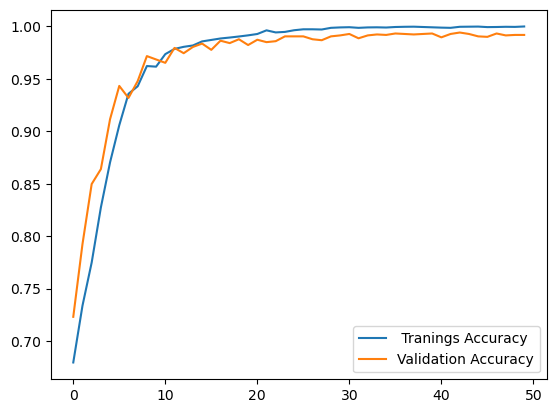

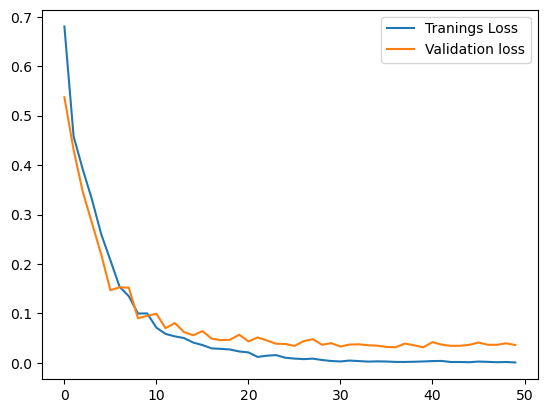

In [14]:
plt.plot(model_history.history['accuracy'], label=' Tranings Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(model_history.history['loss'], label='Tranings Loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

## Test Accuracy

In [15]:
results = model.evaluate(x_test, y_test, batch_size=128)
print("Test accuracy:", np.round(results[1]*100, 2), "%")

18/18 [==============================] - 0s 7ms/step - loss: 0.0349 - accuracy: 0.9922
Test accuracy: 99.22 %


# Konfusion Matrix

18/18 [==============================] - 0s 4ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


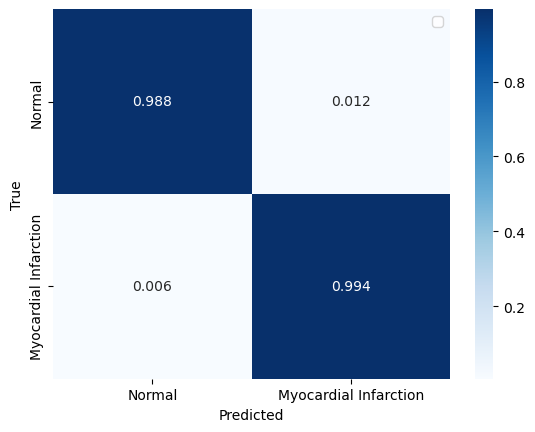

In [16]:
test_pred = model.predict(x_test, batch_size=batch_size)
test_pred = np.argmax(test_pred, axis=-1)
test_true = np.argmax(y_test, axis=-1)

cm = confusion_matrix(test_true, test_pred, normalize='true')
sns.heatmap(cm, annot=True, fmt= '.3f', cmap='Blues', xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.legend()
plt.show()

With an accuracy of around 99%, most ECG records were correctly classified.

## Visualization of Attention Maps


To see which features the model pays the most attention to in the time series, the so-called attention scores can be analyzed and plotted together with the time series. 
As described in **Encoder Part**, attention heads relate each point to all other point. This results in an attention score, a matrix that contains an attention score for each point to each point. 
The higher the value in the corresponding attention score, the greater the attention to this point and the more this point is included in future calculations. The attention score can be made visible in the time series by color coding as shown following. The brighter or more yellow the area in the time series is, the more attention the transformer attracts to this area. \

As described in **Meaning of the Data**, the striking features in the time series for distinguishing the two classes are in the ST and T wave. \

We can now see that the model is paying most attention approximately in this ST and T wave region.

Prediction class: 0
Ground truth class: 0


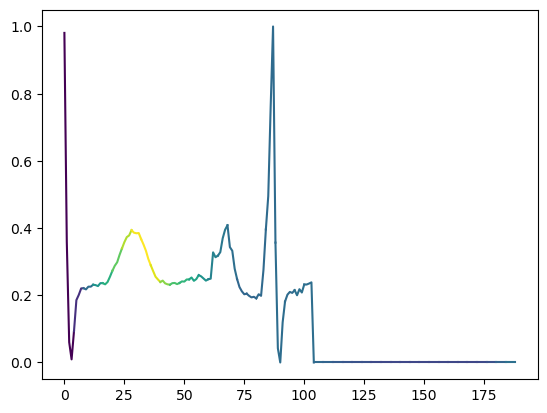

Prediction class: 0
Ground truth class: 0


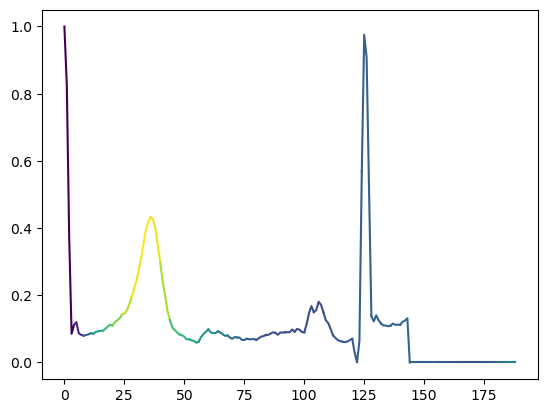

Prediction class: 0
Ground truth class: 0


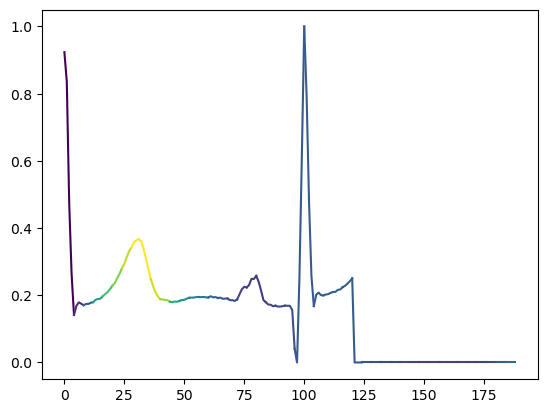

Prediction class: 0
Ground truth class: 0


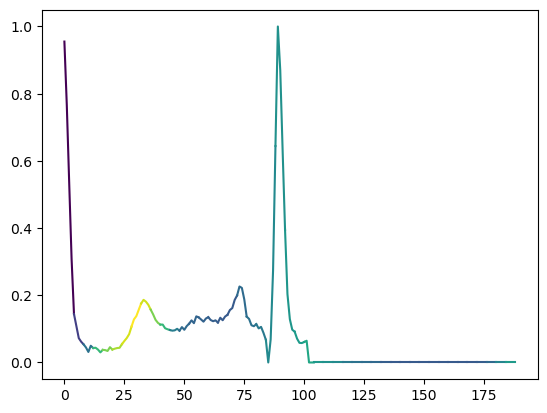

Prediction class: 0
Ground truth class: 0


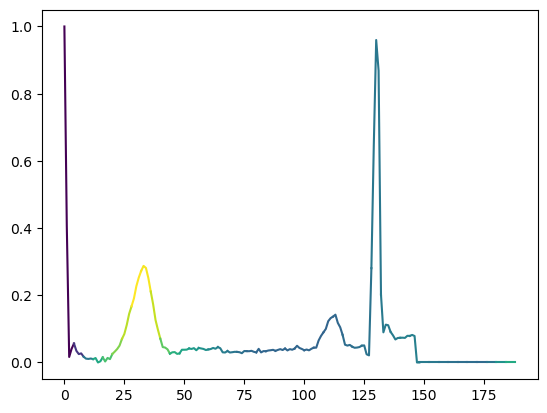

Prediction class: 1
Ground truth class: 1


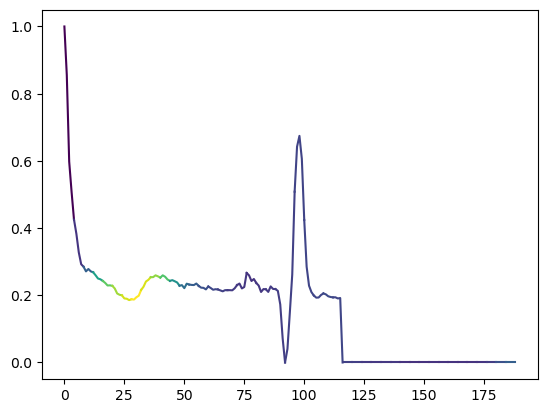

Prediction class: 1
Ground truth class: 1


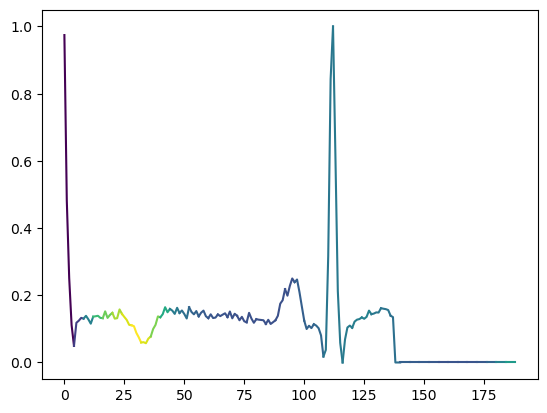

Prediction class: 1
Ground truth class: 1


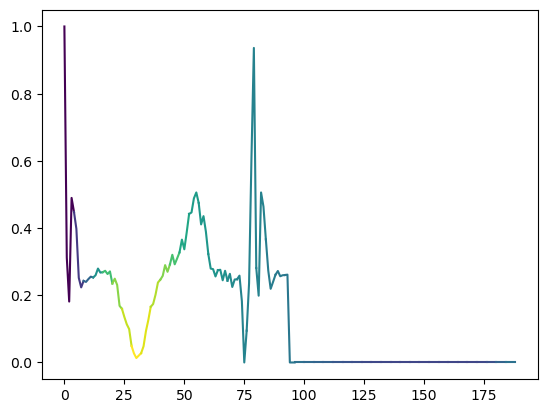

Prediction class: 1
Ground truth class: 1


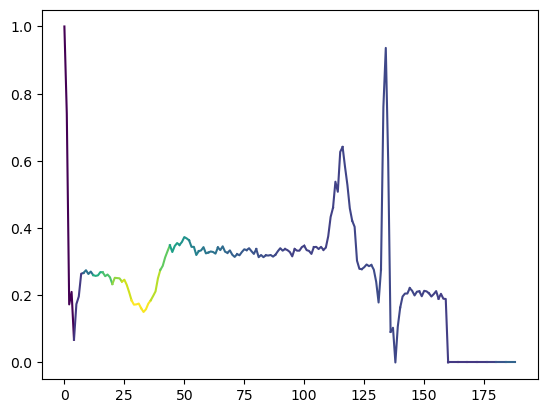

Prediction class: 1
Ground truth class: 1


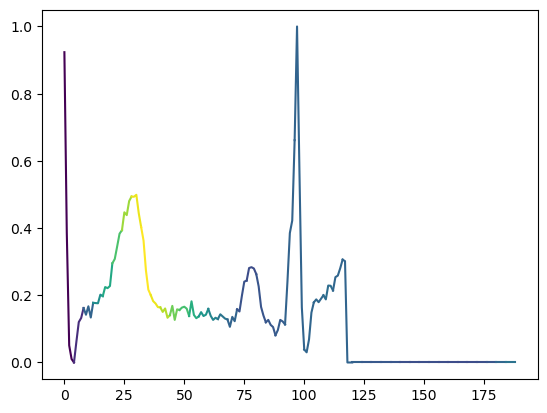

In [17]:
model.visualize_attention_score_within_timeseries(x_test, y_test, number_of_samples_to_plot_from_each_class = 5)